## UFO Reportings Scrape

### Callum Staff

### September 2017

This is code for a webscrape of UFO reports from the [National UFO Reporting Center](http://www.nuforc.org/) (NUFORC) in the United States.

It provides a raw data table containing:
* When the occurrence was
* When the occurrence was reported
* When the occurrence was posted on NUFORC
* Where the occurence was
* The shape of the UFO
* The duration of the occurrence
* A description of the occurrence

The data webscraped in this script has not been cleaned.

Before we start though, we need to load in the libraries we require, and if scraping from a secure network, set the proxies.

In [7]:
#Load in required libraries
import pandas as pd
import requests
from requests.auth import HTTPProxyAuth
from lxml import html
import timeit
import sys
import matplotlib.pyplot as plt
import numpy as np
from lxml.etree import XMLSyntaxError
import os

In [20]:
#Set scrape proxy
proxy_string = 'http://192.168.2.40:8080'
requests = requests.Session()
requests.trust_env=False
requests.proxies = {"http": proxy_string , "https": proxy_string}
requests.auth = HTTPProxyAuth("ad\USERNAME","PASSWORD")

### Webscraping

The process for the webscraping will be:
1. Scrape the links for the month in which the occurence was: [http://www.nuforc.org/webreports/ndxevent.html](http://www.nuforc.org/webreports/ndxevent.html)
2. Scrape the links for each occurrence (an example [here](http://www.nuforc.org/webreports/ndxe201709.html) - see links on lefthand side)
3. Scrape the content for each occurrence

In [30]:
#Set the URL where the monthly occurence links are: base_url
base_url = 'http://www.nuforc.org/webreports/ndxevent.html'

In [31]:
### Scrape the first page using the base_url variable

#Create empty links to scrape the data into
links_list = []
titles_list = []

page = requests.get(base_url) #This sends a request to url_base and gets the contents of the webpage back
tree = html.fromstring(page.content) #This turns the contents of the webpage into a tree
links = tree.xpath('//font/a/@href') #This is the XPath for the hyperlink to each of the months
links = ['http://www.nuforc.org/webreports/' + url for url in links] #This concatenates the hyperlink with the site url
title = tree.xpath('//font/a/text()') #This is the Xpath for the title of each thread, as detailed above
links_list = links_list + links #This adds each link to the empty list
titles_list = titles_list + title #This adds each title to the empty list

In [32]:
#Compile monthly report links into a dictionary and dataframe and then print
monthly_reports = {"Date": titles_list,
                  "URL": links_list}
monthly_reports_df = pd.DataFrame(monthly_reports)
monthly_reports_df[0:9]

,Date,URL
0,09/2017,http://www.nuforc.org/webreports/ndxe201709.html
1,08/2017,http://www.nuforc.org/webreports/ndxe201708.html
2,07/2017,http://www.nuforc.org/webreports/ndxe201707.html
3,06/2017,http://www.nuforc.org/webreports/ndxe201706.html
4,05/2017,http://www.nuforc.org/webreports/ndxe201705.html
5,04/2017,http://www.nuforc.org/webreports/ndxe201704.html
6,03/2017,http://www.nuforc.org/webreports/ndxe201703.html
7,02/2017,http://www.nuforc.org/webreports/ndxe201702.html
8,01/2017,http://www.nuforc.org/webreports/ndxe201701.html


In [ ]:
#For each month, scrape the links to each occurence

#Create empty lists to scrape the data into
report_links = []

#Create empty lists to show time taken and predicted time taken
time_elapsed = []
pred_completion = []

#Create objects to record number of pages scraped and time taken
counter = 0
start = timeit.default_timer()

for page_url in monthly_reports_df['URL']:
    page = requests.get(page_url) #This sends a request to url_base and gets the contents of the webpage back
    tree = html.fromstring(page.content) #This turns the contents of the webpage into a tree
    links = tree.xpath('//font/a/@href') #This is the XPath for the hyperlink to each of the reports, detailed above
    links = ['http://www.nuforc.org/webreports/' + url for url in links] #This concatenates the hyperlink with the site url
    report_links = report_links + links #This adds each link to the empty list
    
    #Record time taken and number of pages scraped
    counter +=1
    stop = timeit.default_timer()
    
    time_elapsed.append(str((stop - start)/60))
    pred_completion.append(str((stop - start)/counter*len(titles_list)/60))
    
    print(counter) #Number of pages scraped
    print(round((stop - start)/60,2)) #Time taken
    print(round((stop - start)/counter*len(titles_list)/60,2)) #Predicted time taken

#Compile time recordings and predictions into dictionary
scrape_analysis1 = {"Time Elapsed": time_elapsed,
                 "Predicted Time to Completion": pred_completion}

In [ ]:
#Save URLs and time analysis into CSV, to prevent need to rescrape if running at a later date
pd.DataFrame(scrape_analysis1).to_csv("Links/scrape_analysis1.csv")
pd.DataFrame({"URL":report_links}).to_csv("Links/report_links.csv")

In [3]:
#Reload links to each report from CSV
report_links = pd.read_csv("Links/report_links.csv")
scrape_analysis1 = pd.read_csv("Links/scrape_analysis.csv")
scrape_analysis1[0:9]

,Unnamed: 0,Predicted Time to Completion,Time Elapsed
0,0,23.196383,0.025660
1,1,12.540886,0.027745
2,2,9.151835,0.030371
3,3,7.361431,0.032573
4,4,6.264179,0.034647
5,5,5.563640,0.036927
6,6,5.212423,0.040362
7,7,4.856531,0.042978
8,8,16.655558,0.165819


<hr/>

As a quick aside, let's see how long scrapes were taking and how this affected predictions:

Predicted total time is the time taken so far divided by the number of pages multipled by total number of pages to scrape.

We can see here that early on the pages were taking ages to scrape for som reason, so the predicted time was way higher for this particular scrape (it could vary on each run due to things link network traffic).

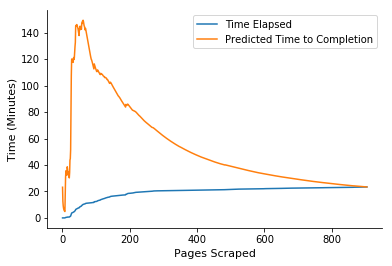

In [4]:
fig, ax = plt.subplots()
plt.rc("figure", facecolor="white")
plt.plot(range(1,len(scrape_analysis1)+1),scrape_analysis1['Time Elapsed'])
plt.plot(range(1,len(scrape_analysis1)+1),scrape_analysis1['Predicted Time to Completion'])
plt.legend(['Time Elapsed', 'Predicted Time to Completion'], loc='upper right')
ax.set_xlabel('Pages Scraped', fontsize = 11)
ax.set_ylabel('Time (Minutes)', fontsize = 11)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [ ]:
#Finally, scrape the content from each report

#Create empty lists to scrape the data into
Occurred = []
Reported = []
Posted = []
Location = []
Shape = []
Duration = []
Description = []

#Create empty lists to show time taken and predicted time taken
time_elapsed = []
pred_completion = []

#Create objects to record number of pages scraped and time taken
counter = 0
start = timeit.default_timer()


for url in report_links['URL']:

    page = requests.get(url) #This sends a request to url_base and gets the contents of the webpage back
<<<<<<< local
=======
    tree = html.fromstring(page.content) #This turns the contents of the webpage into a tree
    Report = tree.xpath('//td/font/text()') #This is the XPath for the report contents, detailed above

    #Here we split up all of the report content data
    #We use a 'try, except...' because some of the links are corrupted, and typically if the script 
    #couldn't find the object it would terminate - the 'try, except...' prevents that
>>>>>>> remote
    try:
        tree = html.fromstring(page.content) #This turns the contents of the webpage into a tree
        Report = tree.xpath('//td/font/text()') #This is the XPath for the report contents, detailed above

        #Here we split up all of the report content data
        try:
            Report_Occurred = Report[0]
        except (IndexError):
            Report_Occurred = '' 
        Occurred = Occurred + [Report_Occurred]

        try:
            Report_Reported = Report[1]
        except (IndexError):
            Report_Reported = ''
        Reported = Reported + [Report_Reported]

        try:
            Report_Posted = Report[2]
        except (IndexError):
            Report_Posted = ''
        Posted = Posted + [Report_Posted]

        try:
            Report_Location = Report[3]
        except (IndexError):
            Report_Location = ''
        Location = Location + [Report_Location]

        try:
            Report_Shape = Report[4]
        except (IndexError):
            Report_Shape = ''
        Shape = Shape + [Report_Shape]

        try:
            Report_Duration = Report[5]
        except (IndexError):
            Report_Duration = ''
        Duration = Duration + [Report_Duration]

        try:
            Report_Description = Report[6:len(Report)]
            Report_Description = ''.join(Report_Description)
        #Report_Description = ''.join(Report[6:len(Report)])
        except (IndexError):
            Report_Description = ''
        Description = Description + [Report_Description]
    
    except XMLSyntaxError:
        continue
    
    #Record time taken and number of pages scraped
    counter +=1
    stop = timeit.default_timer()
    
    time_elapsed.append(str((stop - start)/60))
    pred_completion.append(str((stop - start)/counter*len(report_links)/60))
    
    print(counter) #Number of pages scraped
<<<<<<< local
    print(round((stop - start)/3600,2)) #Time taken
    print(round((stop - start)/counter*9044/3600,2)) #Predicted time taken
=======
    print(round((stop - start)/60,2)) #Time taken
    print(round((stop - start)/counter*len(report_links)/60,2)) #Predicted time taken
>>>>>>> remote

#Compile time recordings and predictions into dictionary
scrape_analysis2 = {"Time Elapsed": time_elapsed,
                 "Predicted Time to Completion": pred_completion}

#Compile into dictionary and dataframe, and save to CSV
Report = {"Occurred":Occurred,
         "Reported":Reported,
         "Posted":Posted,
         "Location":Location,
         "Shape":Shape,
         "Duration":Duration,
         "Description":Description}

#Save URLs and time analysis into CSV, to prevent need to rescrape if running at a later date
pd.DataFrame(Report).to_csv(r"Output/UFO_Reports.csv",encoding="utf-8")

In [20]:
#If CSVs need to be stitched together, as scrape of all data couldn't be run in one go

#Get list of all CSVs in output file
files = [filename for filename in os.listdir("./Output") if filename.endswith(".csv") ]

#Create CSV to be inputted into
UFO_Reports=open("Output/UFO_Reports.csv","a")

# first file:
for line in open("Output/" + files[0]):
    UFO_Reports.write(line)

# now the rest:    
for filename in files[1:len(files)]:
    f = open("Output/" + filename)
    f.next() # skip the header
    for line in f:
         UFO_Reports.write(line)
    f.close()
UFO_Reports.close()